In [2]:
import torch
from pykeops.torch import LazyTensor
import numpy as np
from torchvision.transforms import Resize as tv_resize
from PIL import Image
import time
from torch import nn
import math
import skimage.io as io
import os
import skimage.metrics as sm
from skimage.metrics import structural_similarity as ssim
import lpips
import torchvision
from ROT_RSUOT_RUOT import ROT,RSUOT

/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import sys
  
# Prints the list of directories that the 
# interpreter will search for the required module. 
print(sys.path)

sys.path.insert(0, "/home/prof/smignon/ot_patch_denoising/Wasserstein_Patch_Prior/GitHub_SIAM")

['/home/prof/smignon/ot_patch_denoising/Wasserstein_Patch_Prior/GitHub_SIAM/Denoising_Experiments', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python37.zip', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/lib-dynload', '', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/site-packages', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/site-packages/IPython/extensions', '/home/prof/smignon/.ipython']


### Functions for images 

In [3]:
def save_img(tensor_img, name):
	'''
	save img (tensor form) with the name
	'''
	img = np.clip(tensor_img.squeeze().detach().cpu().numpy(),0,1)
	io.imsave(str(name)+'.png', img)
	return     

def imread(img_name):
    '''
    loads an image as torch.tensor on the selected device
    '''
    np_img = io.imread(img_name)
    tens_img = torch.tensor(np_img, dtype=torch.float, device=DEVICE)
    if torch.max(tens_img) > 1:
        tens_img/=255 													
    if len(tens_img.shape) < 3:
        tens_img = tens_img.unsqueeze(2)						
    if tens_img.shape[2] > 3:										
        tens_img = tens_img[:,:,:3]
    tens_img = tens_img.permute(2,0,1)	
    return tens_img.unsqueeze(0)	

def show(im_deb,col=False):
    im_deb=im_deb.clone().detach()
    im_deb[im_deb>1]=1
    im_deb[im_deb<0]=0
    if col==True:
        im_deb=(255*im_deb.permute(1, 2, 0)).type(dtype=torch.uint8)
    else:
        im_deb=(255*im_deb).type(dtype=torch.uint8)
    imgpil = Image.fromarray(im_deb.numpy()) 
    display(imgpil)
    
class patch_extractor(nn.Module):
    '''
    Module for creating custom patch extractor
    '''
    def __init__(self, patch_size, pad=False,center=False):
        super(patch_extractor, self).__init__()
        self.im2pat = nn.Unfold(kernel_size=patch_size)
        self.pad = pad
        self.padsize = patch_size-1
        self.center=center
        self.patch_size=patch_size

    def forward(self, input, batch_size=0):
        if self.pad:
            input = torch.cat((input, input[:,:,:self.padsize,:]), 2)
            input = torch.cat((input, input[:,:,:,:self.padsize]), 3)
        patches = self.im2pat(input).squeeze(0).transpose(1,0)
        if batch_size > 0:
            idx = torch.randperm(patches.size(0))[:batch_size]
            patches = patches[idx,:]
        if self.center:
            patches = patches - torch.mean(patches,-1).unsqueeze(-1)
        return patches

def PSNR(im,im_new): 
    '''
    Compute PSNR
    '''
    M,N=im_new.shape
    EQM=1/(M*N)*torch.sum((im-im_new)**2)
    psnr=10*torch.log10(1/EQM)
    return(psnr)

loss_fn_alex = lpips.LPIPS(net='alex') # compute LPIPS

    
def Denoising(noisy_img,hr_img,function_OT,n_iter,lbd,lr=0.01,verbose=False,patch_size=6):
    '''
    Denoising using gradient descent
    '''
    # patchs exctractors
    target_im2pat = patch_extractor(patch_size, pad=False,center=False)
    input_im2pat = patch_extractor(patch_size, pad=False,center=False)
    
    # load y patches
    y= hr_img.clone()
    nuY = target_im2pat(y, -1).contiguous()
    
    # load x
    x=noisy_img.clone()
    _,_,N,M=x.shape
    x.requires_grad = True
    
    # optimizer 
    optimizer = torch.optim.Adam([x], lr=lr)
    
    # g_init 
    g_i=None
    
    # initialise Computation time 
    torch.cuda.synchronize()
    t = time.time()
    for i in range(n_iter):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Exctract x patches 
        nuX = input_im2pat(x, -1).contiguous()
        
        # Compute loss
        AD_cost = lbd*(patch_size**2/(N*M))*torch.sum((x-noisy_img)**2)
        OT_cost,g_i = function_OT(nuX,nuY,g_i)
        Total_cost= AD_cost + OT_cost
        
        if verbose==True:
            print('n=',i,', OT: ',OT_cost.clone().item(),', TC: ',Total_cost.clone().item(),', AD: ',AD_cost.clone().item() )
        
        # Compute the gradient
        Total_cost.backward()
        
        # Update x
        optimizer.step()
    
    # Computation time 
    torch.cuda.synchronize()
    time1=int(time.time()-t)
    print('DONE - total time is '+str(time1)+'s')
    
    return x,time1

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


### ROT/RSUOT denoising based on $\varepsilon$ regularization (run to recalculate results, but time-consuming)

In [ ]:
torch.cuda.set_device(2)
DEVICE="cuda"

# Load images 
hr_img=imread('HR_tile.png')
noisy_img=imread('Noisy_tile.png')
ref_img=imread('REF_tile.png')

# Valeur de la régularisation entropique
eps_list=[1e-4,1e-3,1e-2,1e-1,1]

# Lists to save results for ROT
PSNR_ROT=[]
LPIPS_ROT=[]
SSIM_ROT=[]
IM_REST_ROT=[]
TIME_ROT=[]

# Lists to save results for RSUOT
PSNR_RSUOT=[]
LPIPS_RSUOT=[]
SSIM_RSUOT=[]
IM_REST_RSUOT=[]
TIME_RSUOT=[]

for i,eps in enumerate(eps_list):
    # Define ROT
    def R_OT(x,y,fg_init):
        return(ROT(x,y,ε=eps,fg_init=fg_init,nb_it=10,dev=DEVICE))
    
    # Define RSUOT
    def RSU_OT(x,y,f_init):
        return(RSUOT(x,y,ε=eps,ρ=0.01,f_init=f_init,nb_it=10,dev=DEVICE))
    
    #########################################################################################################
    # Denoising 
    denoising_img_ROT,time_ROT=Denoising(noisy_img=noisy_img,hr_img=ref_img,function_OT=R_OT,lbd=0.0329,n_iter=500,lr=0.01,verbose=True,patch_size=6)
    denoising_img_RSUOT,time_RSUOT=Denoising(noisy_img=noisy_img,hr_img=ref_img,function_OT=RSU_OT,lbd=0.0329,n_iter=500,lr=0.001,verbose=True,patch_size=6)
    
    # Mesures associées:
    # PSNR:
    PSNR_ROT.append(PSNR(torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12),
                           torchvision.transforms.functional.crop(denoising_img_ROT.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12)).item())
    PSNR_RSUOT.append(PSNR(torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12),
                           torchvision.transforms.functional.crop(denoising_img_RSUOT.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12)).item())
    # LPIPS:
    LPIPS_ROT.append(loss_fn_alex(torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).unsqueeze(0).unsqueeze(0)
                                  , torchvision.transforms.functional.crop(denoising_img_ROT.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).unsqueeze(0).unsqueeze(0)))
    LPIPS_RSUOT.append(loss_fn_alex(torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).unsqueeze(0).unsqueeze(0)
                                  , torchvision.transforms.functional.crop(denoising_img_RSUOT.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).unsqueeze(0).unsqueeze(0)))
    # SSIM:
    img_hr=torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).detach().numpy()
    img_pred_ROT=torchvision.transforms.functional.crop(denoising_img_ROT.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).detach().numpy()
    img_pred_RSUOT=torchvision.transforms.functional.crop(denoising_img_RSUOT.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).detach().numpy()

    SSIM_ROT.append(ssim(img_hr, img_pred_ROT,data_range=img_pred_ROT.max() - img_pred_ROT.min()))
    SSIM_RSUOT.append(ssim(img_hr, img_pred_RSUOT,data_range=img_pred_RSUOT.max() - img_pred_RSUOT.min()))
    
    # TIME
    TIME_ROT.append(time_ROT)
    TIME_RSUOT.append(time_RSUOT)
    
    # IM REST
    IM_REST_ROT.append(denoising_img_ROT.clone().to('cpu'))
    IM_REST_RSUOT.append(denoising_img_RSUOT.clone().to('cpu'))
    
#torch.save(PSNR_ROT,"PSNR_ROT") # Uncomment to save new results 
#torch.save(PSNR_RSUOT,"PSNR_RSUOT") # Uncomment to save new results 

#torch.save(SSIM_ROT,"SSIM_ROT") # Uncomment to save new results 
#torch.save(SSIM_RSUOT,"SSIM_RSUOT") # Uncomment to save new results 

#torch.save(LPIPS_ROT,"LPIPS_ROT") # Uncomment to save new results 
#torch.save(LPIPS_RSUOT,"LPIPS_RSUOT") # Uncomment to save new results 

#torch.save(IM_REST_ROT,"IM_REST_ROT") # Uncomment to save new results 
#torch.save(IM_REST_RSUOT,"IM_REST_RSUOT") # Uncomment to save new results 

#torch.save(TIME_ROT,"TIME_ROT") # Uncomment to save new results 
#torch.save(TIME_RSUOT,"TIME_RSUOT") # Uncomment to save new results 

### Results 

In [4]:
# Load results 

L_PSNR_ROT=torch.load('PSNR_ROT')
L_PSNR_RSUOT=torch.load('PSNR_RSUOT')

L_LPIPS_ROT=torch.load('LPIPS_ROT')
L_LPIPS_RSUOT=torch.load('LPIPS_RSUOT')

L_SSIM_ROT=torch.load('SSIM_ROT')
L_SSIM_RSUOT=torch.load('SSIM_RSUOT')

L_IM_ROT=torch.load('IM_REST_ROT')
L_IM_RSUOT=torch.load('IM_REST_RSUOT')

L_TIME_ROT=torch.load('TIME_ROT')
L_TIME_RSUOT=torch.load('TIME_RSUOT')

----------------------------
ROT , ε= 0.0001


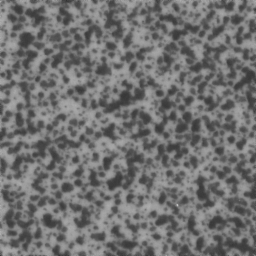

PSNR= 25.50539779663086
SSIM= 0.7700369290010829
LPIPS= 0.07851813733577728
time= 725 s
----------------------------
ROT , ε= 0.001


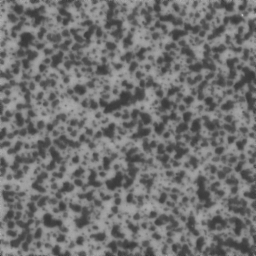

PSNR= 25.807174682617188
SSIM= 0.7776016388164451
LPIPS= 0.07948440313339233
time= 726 s
----------------------------
ROT , ε= 0.01


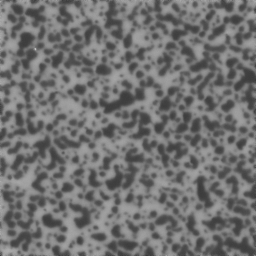

PSNR= 26.66739273071289
SSIM= 0.814019909879914
LPIPS= 0.12553536891937256
time= 726 s
----------------------------
ROT , ε= 0.1


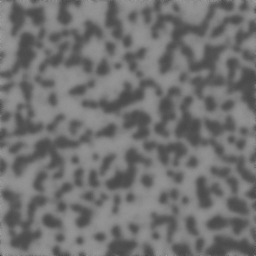

PSNR= 23.881916046142578
SSIM= 0.5220565638617757
LPIPS= 0.4773312211036682
time= 725 s
----------------------------
ROT , ε= 1


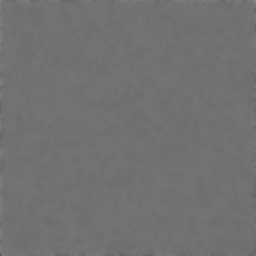

PSNR= 19.833480834960938
SSIM= 0.0788565650813399
LPIPS= 0.6243024468421936
time= 726 s


In [5]:
# Results with ROT
eps_list=[1e-4,1e-3,1e-2,1e-1,1]
for i in range(5):
    print('----------------------------')
    print("ROT",", ε=",eps_list[i])
    show(L_IM_ROT[i].detach().squeeze().to('cpu'),col=False)
    print("PSNR=",L_PSNR_ROT[i])
    print("SSIM=",L_SSIM_ROT[i])
    print("LPIPS=",L_LPIPS_ROT[i].item())
    print("time=",L_TIME_ROT[i],"s")

----------------------------
RSUOT , ε= 0.0001 , ρ= 0.01


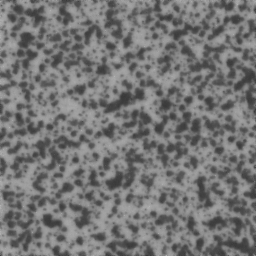

PSNR= 27.112403869628906
SSIM= 0.8098595164977693
LPIPS= 0.06789255142211914
time= 725 s
----------------------------
RSUOT , ε= 0.001 , ρ= 0.01


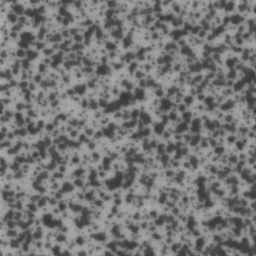

PSNR= 27.078733444213867
SSIM= 0.8086100110059504
LPIPS= 0.06852450221776962
time= 726 s
----------------------------
RSUOT , ε= 0.01 , ρ= 0.01


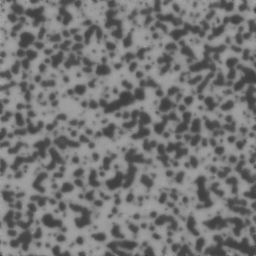

PSNR= 27.111339569091797
SSIM= 0.8031829967479256
LPIPS= 0.14028383791446686
time= 726 s
----------------------------
RSUOT , ε= 0.1 , ρ= 0.01


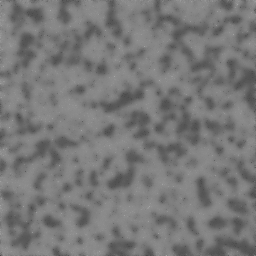

PSNR= 23.353193283081055
SSIM= 0.45540946432834484
LPIPS= 0.3652138113975525
time= 726 s
----------------------------
RSUOT , ε= 1 , ρ= 0.01


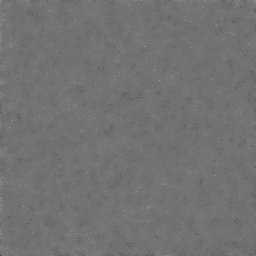

PSNR= 20.150142669677734
SSIM= 0.15256360920940354
LPIPS= 0.546085774898529
time= 726 s


In [6]:
# Results with RSUOT
eps_list=[1e-4,1e-3,1e-2,1e-1,1]
for i in range(5):
    print('----------------------------')
    print("RSUOT",", ε=",eps_list[i],", ρ=",0.01)
    show(L_IM_RSUOT[i].detach().squeeze().to('cpu'),col=False)
    print("PSNR=",L_PSNR_RSUOT[i])
    print("SSIM=",L_SSIM_RSUOT[i])
    print("LPIPS=",L_LPIPS_RSUOT[i].item())
    print("time=",L_TIME_RSUOT[i],"s")